# TGIR-Cap3DXWeaviate

Text-guided image retrieval using the Cap3D dataset and the Weaviate vector database (`v4.5.6`).

## Minimal Example

### gRPC

Note:
The `v4` client uses remote procedure calls (RPCs) under-the-hood.
Accordingly, a port for gRPC must be open to your Weaviate server.

<details>
  <summary>docker-compose.yml example:</summary><br>
  
  If you are running Weaviate with Docker, you can map the default port (`50051`) by adding the following to your `docker-compose.yml` file:

  ```yaml
  ports:
    - 8080:8080
    - 50051:50051
  ```

</details>


### Helper classes

<details>
  <summary>List of `weaviate.classes` submodules:</summary><br>
  
  | Module                | Description                  |
  |-----------------------|------------------------------|
  | `weaviate.classes.config`     | Collection creation / modification  |
  | `weaviate.classes.data`       | CUD operations                      |
  | `weaviate.classes.query`      | Query/search operations             |
  | `weaviate.classes.aggregate`  | Aggregate operations                |
  | `weaviate.classes.generic`    | Generics                            |
  | `weaviate.classes.init`       | Initialization                      |
  | `weaviate.classes.tenants`    | Tenants                             |
  | `weaviate.classes.batch`      | Batch operations                    |

</details>


```python
import weaviate

import weaviate.classes as wvc
from weaviate.collections.classes.grpc import Move
import os

client = weaviate.connect_to_local()

try:
    publications = client.collections.get("Publication")

    response = publications.query.near_text(
        query="fashion",
        distance=0.6,
        move_to=Move(force=0.85, concepts="haute couture"),
        move_away=Move(force=0.45, concepts="finance"),
        return_metadata=wvc.query.MetadataQuery(distance=True),
        limit=2,
    )

    for o in response.objects:
        print(o.properties)
        print(o.metadata)

finally:
    client.close()
```

## Connection termination

You must ensure your client connections are closed. You can use `client.close()`, or use a context manager to close client connections for you.

### client.close() with try / finally

This will close the client connection when the `try` block is complete (or if an exception is raised).

In [9]:
import weaviate

try:
    client = weaviate.connect_to_local()  # Connect with default parameters
    print("Client connection established")

    try:
        print("Doing something with the client")
        pass  # Do something with the client

    except Exception as e:
        print(f"client operation failed: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

finally:
    print("Closing client connection")
    client.close()  # Ensure the connection is closed

Client connection established
Doing something with the client
Closing client connection


### Context manager

This will close the client connection when you leave the `with` block.

In [10]:
import weaviate

with weaviate.connect_to_local() as client:
    print("Client connection established")

    try:
        print("Doing something with the client")
        pass  # Do something with the client

    except Exception as e:
        print(f"client operation failed: {e}")

    print("Closing client connection")
    pass
    # The connection is closed automatically when the context manager exits

Client connection established
Doing something with the client
Closing client connection


## Timeout values

You can set timeout values, in seconds, for the client.
Use the `Timeout` class to configure the timeout values for initialization checks as well as query and insert operations.

In [11]:
import weaviate
from weaviate.classes.init import AdditionalConfig, Timeout

HTTP_PORT = 8080
GRPC_PORT = 50051

INTIALISATION_TIMEOUT_S = 2
QUERY_TIMEOUT_S = 45
INSERT_TIMEOUT_S = 120

with weaviate.connect_to_local(
    port=HTTP_PORT,
    grpc_port=GRPC_PORT,
    additional_config=AdditionalConfig(
        timeout=Timeout(
            init=INTIALISATION_TIMEOUT_S, query=QUERY_TIMEOUT_S, insert=INSERT_TIMEOUT_S
        )  # Values in seconds
    ),
) as client:
    print("Client connection established")

    try:
        print("Doing something with the client")
        pass  # Do something with the client

    except Exception as e:
        print(f"client operation failed: {e}")

    print("Closing client connection")
    pass
    # The connection is closed automatically when the context manager exits

Client connection established
Doing something with the client
Closing client connection


### Timouts on `generate` (RAG) queries

If you see errors while using the `generate` submodule, try increasing the query timeout values (`Timeout(query=60)`).

The `generate` submodule uses a large language model to generate text. The submodule is dependent on the speed of the language model and any API that serves the language model.

Increase the timeout values to allow the client to wait longer for the language model to respond.

## Python client v4 explicit connection

If you need to pass custom parameters, use the `weaviate.WeaviateClient` class to instantiate a client.
This is the most flexible way to instantiate the client object.

Please note that when directly instantiating a connection, you must connect to the server manually by calling the `.connect()` method.

In [25]:
import weaviate
from weaviate.connect import ConnectionParams
from weaviate.classes.init import AdditionalConfig, Timeout
import os


HTTP_HOST = "localhost"
HTTP_PORT = 8080
HTTP_SECURE = False

GRPC_HOST = "localhost"
GRPC_PORT = 50051
GRPC_SECURE = False

INTIALISATION_TIMEOUT_S = 2
QUERY_TIMEOUT_S = 45
INSERT_TIMEOUT_S = 120


client = weaviate.WeaviateClient(
    connection_params=ConnectionParams.from_params(
        http_host=HTTP_HOST,
        http_port=HTTP_PORT,
        http_secure=HTTP_SECURE,
        grpc_host=GRPC_HOST,
        grpc_port=GRPC_PORT,
        grpc_secure=GRPC_SECURE,
    ),  # ConnectError, WeaviateConnectionError, WeaviateStartUpError
    # auth_client_secret=weaviate.auth.AuthApiKey(
    #     "secr3tk3y"
    # ),  # UnexpectedStatusCodeError
    # additional_headers={"X-OpenAI-Api-Key": os.getenv("OPENAI_APIKEY")},
    additional_config=AdditionalConfig(
        timeout=Timeout(
            init=INTIALISATION_TIMEOUT_S, query=QUERY_TIMEOUT_S, insert=INSERT_TIMEOUT_S
        ),  # Values in seconds
    ),
)

client.connect()  # When directly instantiating, you need to connect manually

## Collections

Every object in Weaviate belongs to exactly one collection. Use the examples on this page to manage your collections.

Note:
Newer Weaviate documentation discuses "collections."
Older Weaviate documentation refers to "classes" instead.
Expect to see both terms throughout the documentation.

### Create a collection

To create a collection, specify at least the collection name.
If you don't specify any properties, `auto-schema` creates them.

```python
client.collections.create("Cap3D")
```

Tutorials:
* [Developer Academy](https://weaviate.io/developers/academy/py/starter_multimodal_data/mm_collections/create_collection) (Weaviate v4)
* [Documentation](https://weaviate.io/developers/weaviate/modules/retriever-vectorizer-modules/multi2vec-clip#example-1) (Weaviate v3)

In [31]:
import weaviate.classes.config as wc

wc.Property(
    name="title", data_type=wc.DataType.TEXT, description="Description of image"
)

Property(name='title', dataType=<DataType.TEXT: 'text'>, description='Description of image', indexFilterable=None, indexSearchable=None, nestedProperties=None, skip_vectorization=False, tokenization=None, vectorize_property_name=True)

In [92]:
import json

assert client.is_live()  # This will raise an exception if the client is not live

metainfo = client.get_meta()
print(json.dumps(metainfo, indent=4))  # Print the meta information in a readable format

{
    "hostname": "http://[::]:8080",
    "modules": {
        "multi2vec-clip": {
            "clip_model": {
                "_commit_hash": null,
                "_name_or_path": "/root/.cache/torch/sentence_transformers/sentence-transformers_clip-ViT-B-32/0_CLIPModel",
                "add_cross_attention": false,
                "architectures": [
                    "CLIPModel"
                ],
                "bad_words_ids": null,
                "begin_suppress_tokens": null,
                "bos_token_id": null,
                "chunk_size_feed_forward": 0,
                "cross_attention_hidden_size": null,
                "decoder_start_token_id": null,
                "diversity_penalty": 0,
                "do_sample": false,
                "early_stopping": false,
                "encoder_no_repeat_ngram_size": 0,
                "eos_token_id": null,
                "exponential_decay_length_penalty": null,
                "finetuning_task": null,
                "f

In [148]:
import weaviate.classes.config as wc

COLLECTION_NAME = "Cap3DMM"

client.collections.delete(COLLECTION_NAME)

client.collections.create(
    COLLECTION_NAME,  # The name of the collection ('MM' for multimodal)
    description="A Cap3D collection for multi2vec-clip",
    properties=[
        wc.Property(
            name="image",
            data_type=wc.DataType.BLOB,  # base64-encoded string
            description="Image",
        ),
        wc.Property(
            name="description",
            data_type=wc.DataType.TEXT,
            description="Description of image",
        ),
        wc.Property(
            name="datasetUID",
            data_type=wc.DataType.TEXT,
            description="A concatenation of the Unique ID and the name of the image from dataset",
        ),
        # wc.Property(name="vote_average", data_type=wc.DataType.NUMBER),
        # wc.Property(name="genre_ids", data_type=wc.DataType.INT_ARRAY),
        # wc.Property(name="release_date", data_type=wc.DataType.DATE),
    ],
    vectorizer_config=wc.Configure.Vectorizer.multi2vec_clip(
        image_fields=[
            wc.Multi2VecField(name="image", weight=0.9)
        ],  # 90% of the vector is from the poster
        text_fields=[
            wc.Multi2VecField(name="description", weight=0.1)
        ],  # 10% of the vector is from the title),
    ),
    # # Define the generative module
    # generative_config=wc.Configure.Generative.openai()
    # qna_config=wc.Configure.Generative.transformers()  # EXPERIMENT
)

In [150]:
# Get the collection
collection = client.collections.get("Cap3DMM")
collection.aggregate.over_all(total_count=True)

AggregateReturn(properties={}, total_count=0)

In [50]:
import weaviate
import pandas as pd
import requests
from datetime import datetime, timezone
import json
from weaviate.util import generate_uuid5
from tqdm import tqdm
import os
import zipfile
from pathlib import Path
import base64

<frozen importlib._bootstrap_external>:729: ResourceWarning: unclosed <socket.socket fd=73, family=2, type=1, proto=6, laddr=('127.0.0.1', 36588), raddr=('127.0.0.1', 8080)>
<frozen importlib._bootstrap_external>:729: ResourceWarning: unclosed <socket.socket fd=69, family=2, type=1, proto=6, laddr=('127.0.0.1', 52462), raddr=('127.0.0.1', 8080)>


NOTE: This is adding each image to the DB, rather, we want to average the embedding for all of the images and add that to the db

In [151]:
BATCH_SIZE = 5
PATH_TO_EXAMPLE_OBJECT = "/home/yunusskeete/Documents/data/3D/Cap3D/example-object/c5517f31ede34ad0a0da1f38753f9588"
path_to_example_object = Path(PATH_TO_EXAMPLE_OBJECT)
OBJECT_DESCRIPTION = "A dog of breed pug"  # Static as only one image, will be sourced from Cap3D pipeline

object_uuids = []

# Enter context manager
with collection.batch.fixed_size(BATCH_SIZE) as batch:
    # Loop through the data
    for idx, image_file in tqdm(
        enumerate(
            file
            for file in path_to_example_object.iterdir()
            if file.suffix == ".png" and "_" not in file.name
        )
    ):
        # Convert image to base64
        with image_file.open("rb") as file:
            image_b64 = base64.b64encode(file.read()).decode("utf-8")

        # Build the object payload
        obj = {
            "image": image_b64,
            "description": OBJECT_DESCRIPTION,
            "datasetUID": f"{image_file.parent.name}_{image_file.name}",  # E.g. "c5517f31ede34ad0a0da1f38753f9588_00005.png"
        }

        object_uuid = generate_uuid5(obj["datasetUID"])
        # Add object to batch queue
        batch.add_object(
            properties=obj,
            uuid=object_uuid,
            # references=reference_obj  # You can add references here
        )
        object_uuids.append(object_uuid)
        # Batcher automatically sends batches

# Check for failed objects
if len(objects.batch.failed_objects) > 0:
    print(f"Failed to import {len(objects.batch.failed_objects)} objects")
    for failed in objects.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")

20it [00:00, 102.74it/s]


In [107]:
from typing import Optional


def pad_number(number: int, length: Optional[int] = 5) -> str:
    """Converts an integer to a string and pads the string with zeros to achieve a certain string length

    Parameters
    ----------
    number : int
        number to pad
    number : Optional(int)
        desired padded number length

    Returns
    -------
    str
        Padded number of length `length`

    Raises
    ------
    ValueError
        Raises error when `number` has more digits than the `length`

    Example Usage
    -------------
    >>> [pad_number(x) for x in range(5)]
    ['00000', '00001', '00002', '00003', '00004']
    """
    # Convert the number to a string
    num_str: str = str(number)

    # Check if the number has more than 5 digits
    if len(num_str) > length:
        raise ValueError(
            f"The number has more than {length} digits and cannot be converted into a {lenght}-character string."
        )

    # Pad with zeros to make it 5 characters long
    padded_str = num_str.zfill(5)

    return padded_str

Query image:


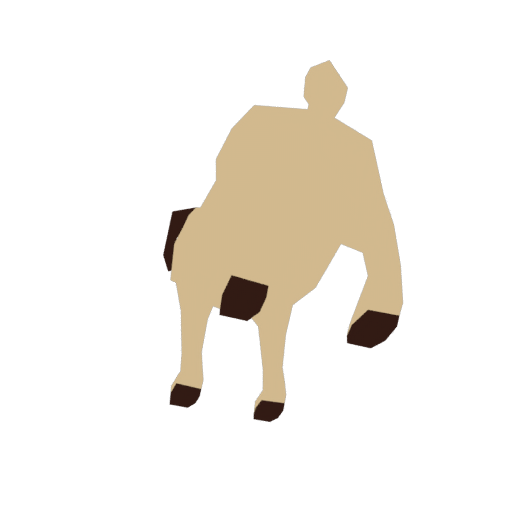


Retrieved images
Description: A dog of breed pug
Dataset UID: c5517f31ede34ad0a0da1f38753f9588_00003.png
Distance to query: 0.003



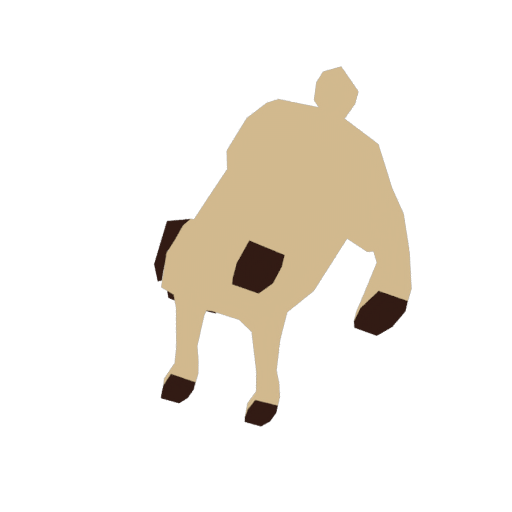

Description: A dog of breed pug
Dataset UID: c5517f31ede34ad0a0da1f38753f9588_00004.png
Distance to query: 0.003



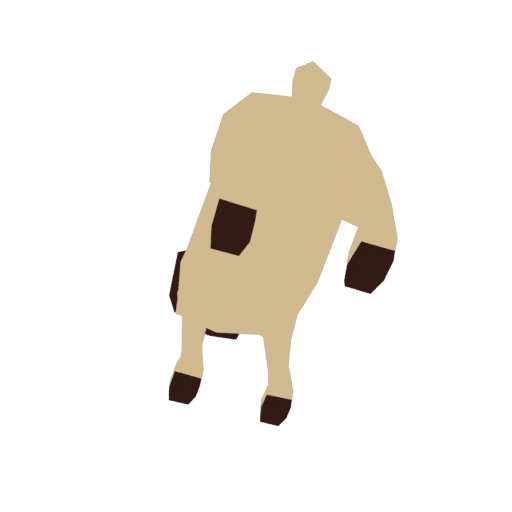

Description: A dog of breed pug
Dataset UID: c5517f31ede34ad0a0da1f38753f9588_00011.png
Distance to query: 0.003



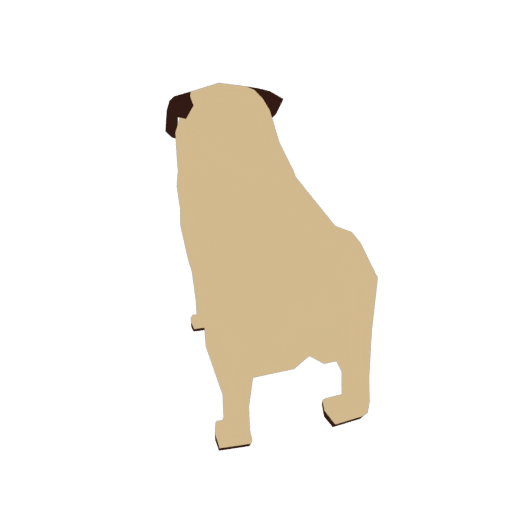

Description: A dog of breed pug
Dataset UID: c5517f31ede34ad0a0da1f38753f9588_00016.png
Distance to query: 0.003



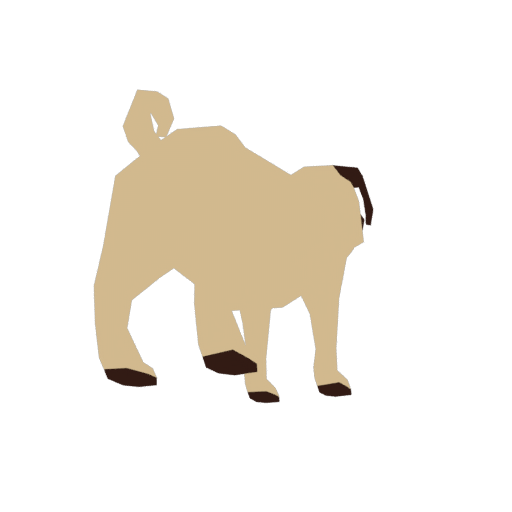

In [137]:
import weaviate
import weaviate.classes.query as wq
import os

# Instantiate your client (not shown). e.g.:
# headers = {"X-OpenAI-Api-Key": os.getenv("OPENAI_APIKEY")}  # Replace with your OpenAI API key
# client = weaviate.connect_to_local(headers=headers)


def url_to_base64(url):
    import requests
    import base64

    image_response = requests.get(url)
    content = image_response.content
    return base64.b64encode(content).decode("utf-8")


def display_base64(base64_string):
    import base64
    from io import BytesIO
    from PIL import Image
    from IPython.display import display

    # Step 1: Decode the Base64 string into bytes
    image_data = base64.b64decode(base64_string)

    # Step 2: Create a Pillow image object from the bytes
    image = Image.open(BytesIO(image_data))

    # Step 3: Use IPython's display to show the image in the notebook
    display(image)  # Display using Pillow Image object


# Get the collection
collection = client.collections.get("Cap3DMM")

# Perform query
image_no = 0
src_img_path = f"https://huggingface.co/datasets/tiange/Cap3D/resolve/main/RenderedImage_perobj_zips/example_zipfile/{pad_number(image_no)}.png?download=true"
query_b64 = url_to_base64(src_img_path)
query_uid = f"{path_to_example_object.name}_{pad_number(image_no)}.png"
print("Query image:")
display_base64(query_b64)
print()

response = collection.query.near_image(
    near_image=query_b64,
    limit=5,
    return_metadata=wq.MetadataQuery(
        creation_time=True,
        last_update_time=True,
        distance=True,
        certainty=True,
        score=True,
        # explain_score=True,
        # is_consistent=True,
        # rerank_score=True,
    ),
    return_properties=[
        "image",
        "description",
        "datasetUID",
    ],  # To include the image property in the response (`blob` properties are not returned by default)
)

print("Retrieved images")
# Inspect the response
for obj in (
    res for res in response.objects if res.properties["datasetUID"] != query_uid
):
    print(f"Description: {obj.properties['description']}")
    print(f"Dataset UID: {obj.properties['datasetUID']}")
    # Print the title and release year (note the release date is a datetime object)
    print(
        f"Distance to query: {o.metadata.distance:.3f}\n"
    )  # Print the distance of the object from the query

    display_base64(obj.properties["image"])

# client.close()

In [125]:
obj.__dict__

{'uuid': _WeaviateUUIDInt('7af04537-2bc5-54e0-83c3-c31f52bbf212'),
 'metadata': MetadataReturn(creation_time=datetime.datetime(2024, 4, 30, 11, 45, 14, 224000, tzinfo=datetime.timezone.utc), last_update_time=datetime.datetime(2024, 4, 30, 11, 45, 14, 224000, tzinfo=datetime.timezone.utc), distance=0.0730588436126709, certainty=0.9634705781936646, score=0.0, explain_score='', is_consistent=None, rerank_score=None),
 'properties': {'description': 'A dog of breed pug',
  'image': 'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AACaLUlEQVR4nO39d5wc15nfC/+equ6eDNQgZzQCs0g0mECKkjiUSGWRoKRN3kDSvn5f2+s1RX/8XvvaXnPhe329tvY1Ba/kdO0luNpd7S4pESQVViSXHCqQYESDOQBgA0ROU5OnQ53n/lGhq6urOsz0THfPPF9yUF1Vp06dququJ55zAEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQB

In [126]:
obj.collection

'Cap3DMM'

In [131]:
obj.metadata

MetadataReturn(creation_time=datetime.datetime(2024, 4, 30, 11, 45, 14, 224000, tzinfo=datetime.timezone.utc), last_update_time=datetime.datetime(2024, 4, 30, 11, 45, 14, 224000, tzinfo=datetime.timezone.utc), distance=0.0730588436126709, certainty=0.9634705781936646, score=0.0, explain_score=None, is_consistent=None, rerank_score=None)

In [132]:
obj.properties

{'description': 'A dog of breed pug',
 'image': 'iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAYAAAD0eNT6AACaLUlEQVR4nO39d5wc15nfC/+equ6eDNQgZzQCs0g0mECKkjiUSGWRoKRN3kDSvn5f2+s1RX/8XvvaXnPhe329tvY1Ba/kdO0luNpd7S4pESQVViSXHCqQYESDOQBgA0ROU5OnQ53n/lGhq6urOsz0THfPPF9yUF1Vp06dququJ55zAEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEEQBEGYh1CzGyC0Pr/1tVtSCU3hwtC

In [133]:
obj.references

In [134]:
obj.uuid

_WeaviateUUIDInt('7af04537-2bc5-54e0-83c3-c31f52bbf212')

In [135]:
obj.vector

{}

In [138]:
collection.aggregate.over_all(total_count=True)

AggregateReturn(properties={}, total_count=20)

In [147]:
generate_uuid5(obj.properties["datasetUID"])

'7af04537-2bc5-54e0-83c3-c31f52bbf212'

In [154]:
object_uuids

['c928f799-dfc9-562b-b688-1d474178bf68',
 'a5c352fd-893e-535a-ab4d-0b21b31a6efc',
 '8924c274-5920-5835-a487-9af690dd72e1',
 'a2942720-41f8-5b1a-8b0b-39aec9e14f2d',
 'fbb383dd-7abd-5238-86c1-a806822ab6f3',
 'ea0889e8-3942-5f78-9b4d-9e3f99129ef0',
 '180446a2-f8c4-546a-a3f0-8907a686925c',
 '107efac4-ad9a-5856-92a3-33e0e679baeb',
 'bbd7fabb-838b-59e6-847a-baf2e6c2eb2b',
 '58d53fd7-48f1-5c73-b5cc-496f64963331',
 '7af04537-2bc5-54e0-83c3-c31f52bbf212',
 '0e4b174f-16ae-5573-a94d-74e3fa6a12e7',
 '2c6103b0-3d30-5623-9987-aec522caa3eb',
 'ee544f6f-a9a2-51ea-add0-713dbf7e6f93',
 '5cb5f8e6-1ebb-5eac-b85f-e88e8b134bff',
 'fa4ba02c-6137-59a0-bb9a-d6c918905451',
 '120f2f5f-7121-5a79-84ec-85e91bfb679a',
 '80ad3370-b267-5a88-a2e2-0d5f8edeacb1',
 'cbd034d9-287b-51cf-a40a-b3d61e24eccf',
 '80975ea8-f9d5-5172-8936-060c885dc95a']

In [165]:
data_objects = [
    collection.query.fetch_object_by_id(uuid, include_vector=True)
    for uuid in object_uuids
]

In [167]:
object_idx = 0
type(data_objects[object_idx].vector), data_objects[object_idx].vector.keys(), type(
    data_objects[object_idx].vector["default"]
), len(data_objects[object_idx].vector["default"])

(dict, dict_keys(['default']), list, 512)

In [168]:
object_idx = 1
type(data_objects[object_idx].vector), data_objects[object_idx].vector.keys(), type(
    data_objects[object_idx].vector["default"]
), len(data_objects[object_idx].vector["default"])

(dict, dict_keys(['default']), list, 512)

In [169]:
object_idx = -1
type(data_objects[object_idx].vector), data_objects[object_idx].vector.keys(), type(
    data_objects[object_idx].vector["default"]
), len(data_objects[object_idx].vector["default"])

(dict, dict_keys(['default']), list, 512)

In [177]:
import numpy as np

vectors = np.array([data_object.vector["default"] for data_object in data_objects])
print(vectors.shape)

average_vector = np.mean(vectors, axis=0)
average_vector.shape

(20, 512)


(512,)

In [178]:
average_vector

array([ 8.86635190e-02, -1.09130854e-01, -3.69217746e-02,  4.62954791e-02,
        2.66403840e-01, -2.06070045e-01,  4.97792080e-02,  3.36323806e-01,
        4.00943610e-02,  1.15694225e-01, -2.50383163e-02,  8.68621292e-02,
        3.08965366e-01, -2.54874388e-02,  9.95474340e-02, -1.95215125e-02,
        3.58344514e-01,  2.37085348e-02, -4.26432774e-02,  4.20975932e-03,
       -1.01573876e-01,  7.36341682e-02,  1.34017451e-01, -8.19713865e-02,
       -1.94062731e-01,  6.99484543e-02, -2.30575500e-01, -2.97070270e-02,
       -2.88029182e-02, -2.50526310e-01,  1.62028364e-01,  1.45112950e-01,
       -2.23518301e-02,  5.34310072e-02,  9.53576688e-02, -8.14462321e-02,
        9.63160931e-04,  6.93706077e-02,  6.13842185e-02, -9.89633520e-02,
       -4.59515347e-01,  1.34079011e-01,  8.20580131e-02, -1.20009670e-01,
       -7.71949676e-02, -2.48362062e-01, -1.37412519e-01,  6.62255905e-02,
        2.23375767e-01, -1.47723411e-01,  1.31443761e-01,  4.62252041e-04,
        2.22194992e-01,  

# TODO: Configure this from YAML file

In [ ]:
from weaviate.classes.config import Configure, Property, DataType

client.collections.create(
    "Cap3D",
    vectorizer_config=Configure.Vectorizer.(),
    properties=[  # properties configuration is optional
        Property(name="title", data_type=DataType.TEXT),
        Property(name="body", data_type=DataType.TEXT),
    ],
)

## Batching

The v4 client offers two ways to perform batch imports. From the client object directly, or from the collection object.

We recommend using the collection object to perform batch imports of single collections or tenants. If you are importing objects across many collections, such as in a multi-tenancy configuration, using client.batch may be more convenient.

### Batch sizing

There are three methods to configure the batching behavior. They are `dynamic`, `fixed_size` and `rate_limit`.

| Method    |	Description |   When to use |
|-----------|---------------|---------------|
|   `dynamic`   | The batch size and the number of concurrent requests are dynamically adjusted on-the-fly during import, depending on the server load. |   Recommended starting point. |
|   `fixed_size`    |   The batch size and number of concurrent requests are fixed to sizes specified by the user.  |   When you want to specify fixed parameters.  |
|   `rate_limit`    |   The number of objects sent to Weaviate is rate limited (specified as n_objects per minute). |   When you want to avoid hitting third-party vectorization API rate limits.   |

### Dynamic batching

```python
import weaviate

client = weaviate.connect_to_local()

try:
    with client.batch.dynamic() as batch:  # or <collection>.batch.dynamic()
        # Batch import objects/references - e.g.:
        batch.add_object(
            properties={"title": "Multitenancy"},
            collection="WikiArticle",
            uuid=src_uuid,
        )
        batch.add_object(
            properties={"title": "Database schema"},
            collection="WikiArticle",
            uuid=tgt_uuid,
        )
        batch.add_reference(
            from_collection="WikiArticle",
            from_uuid=src_uuid,
            from_property="linkedArticle",
            to=tgt_uuid,
        )

finally:
    client.close()
```

## Exceptions

[Docs](https://weaviate-python-client.readthedocs.io/en/v4.5.6/weaviate.exceptions.html)

#### `weaviate.exceptions.AdditionalPropertiesError(additional_dict: str, additional_dataclass: str)`
Additional properties were provided multiple times.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.AdditionalPropertiesException`
Alias of `AdditionalPropertiesError`

#### `weaviate.exceptions.AuthenticationFailedError(message: str = '')`
Authentication Failed Exception.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.AuthenticationFailedException`
Alias of `AuthenticationFailedError`

#### `weaviate.exceptions.BackupFailedError(message: str = '')`
Backup Failed Exception.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.BackupFailedException`
Alias of `BackupFailedError`

#### `weaviate.exceptions.EmptyResponseError(message: str = '')`
Occurs when an HTTP request unexpectedly returns an empty response
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.EmptyResponseException`
Alias of `EmptyResponseError`

#### `weaviate.exceptions.InvalidDataModelError(type_: str)`
Is raised when the user provides a generic that is not supported
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.InvalidDataModelException`
Alias of `InvalidDataModelError`

#### `weaviate.exceptions.MissingScopeError(message: str = '')`
Scope was not provided with client credential flow.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

### `weaviate.exceptions.MissingScopeException`
Alias of `MissingScopeError`

#### `weaviate.exceptions.ObjectAlreadyExistsError(message: str = '')`
Object Already Exists Exception.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.ObjectAlreadyExistsException`
Alias of `ObjectAlreadyExistsError`

#### `weaviate.exceptions.ResponseCannotBeDecodedError(location: str, response: Response | Response)`
Raised when a weaviate response cannot be decoded to json
* Arguments:
    * location:
        * From which code path the exception was raised.
    * response:
        * The request response of which the status code was unexpected.
 > property `status_code: int`

#### `weaviate.exceptions.ResponseCannotBeDecodedException`
Alias of `ResponseCannotBeDecodedError`

#### `weaviate.exceptions.SchemaValidationError(message: str = '')`
Schema Validation Exception.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.SchemaValidationException`
Alias of `SchemaValidationError`

#### `weaviate.exceptions.UnexpectedStatusCodeError(message: str, response: Response | Response)`
Is raised in case the status code returned from Weaviate is not handled in the client implementation and suggests an error.
Custom code can act on the attributes: - status_code - json
* Arguments:
    * message:
        * An error message specific to the context, in which the error occurred.
    * response:
        * The request response of which the status code was unexpected.
 > property `status_code: int`

#### `weaviate.exceptions.UnexpectedStatusCodeException`
Alias of `UnexpectedStatusCodeError`

#### `weaviate.exceptions.WeaviateAddInvalidPropertyError(message: str)`
Is raised when adding an invalid new property.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateBaseError(message: str = '')`
Weaviate base exception that all Weaviate exceptions should inherit from.
***This error can be used to catch any Weaviate exceptions.***
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateBatchError(message: str)`
Is raised if a gRPC batch query to Weaviate fails in any way.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateBatchValidationError(message: str)`
Is raised when a batch validation error occurs.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateClosedClientError`
Is raised when a client is closed and a method is called on it.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateConnectionError(message: str = '')`
Is raised when the connection to Weaviate fails.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateDeleteManyError(message: str)`
Is raised if a gRPC delete many request to Weaviate fails in any way.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateEmbeddedInvalidVersionError(url: str)`
Invalid version provided to Weaviate embedded.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateEmbeddedInvalidVersionException`
Alias of `WeaviateEmbeddedInvalidVersionError`

#### `weaviate.exceptions.WeaviateGRPCUnavailableError(weaviate_version: str = '')`
Is raised when a gRPC-backed query is made with no gRPC connection present.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateGrpcUnavailable`
Alias of `WeaviateGRPCUnavailableError`

#### `weaviate.exceptions.WeaviateInsertInvalidPropertyError(data: dict)`
Is raised when inserting an invalid property.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateInsertManyAllFailedError(message: str = '')`
Is raised when all objects fail to be inserted.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateInvalidInputError(message: str)`
Is raised if the input to a function is invalid.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateInvalidInputException`
Alius of `WeaviateInvalidInputError`

#### `weaviate.exceptions.WeaviateQueryError(message: str, protocol_type: str)`
Is raised if a query (either gRPC or GraphQL) to Weaviate fails in any way.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.

#### `weaviate.exceptions.WeaviateQueryException`
Alias of `WeaviateQueryError`

#### `weaviate.exceptions.WeaviateStartUpError(message: str = '')`
Is raised if weaviate is not available on the given url+port.
* Arguments:
    * message:
        * An error message specific to the context in which the error occurred.